## Plotting The Mass-Radius Relation

In this notebook I use the functions provided in the folder `corecomposition/interpolator` (mostly the functions in `corecomposition/interpolator/interpolator.py`) to plot the mass-radius relation for a couple different models. Eventually I'll use this notebook to determine the SNR needed to distinguish core composition as a function of radius. In the meantime, the main purpose of this code is to ensure that the evolutionary tracks are behaving properly in the interpolation code.

In [1]:
### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('stefan.mplstyle')

### Tools
import sys
sys.path.append('../')
from corecomposition import interpolator
from corecomposition import vgsimulator

sys.path.append('../../')
import WD_models

### Constants
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16
speed_light = 299792458 #m/s

/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/models/warwick_da
We could not find the pickled WD models
We could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.
/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/models/warwick_da


[Sihao's WD_models code](https://github.com/sihaocheng/WD_models) contains mass-radius relations for **ultramassive O/Ne DA & DB WDs** from [these tables](http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/ultramassive.html), which are the same ones that I use for interpolation (they can be found at `corecomposition/interpolator/data/laplata/high_mass/ONe*.dat`). **The only ultramassive C/O models in WD_models are those from Bedard and Fontaine.** Because those models are calculated using different codes (i.e. not LPCODE), it won't be surprising if our C/O models have different gravz than those from WD_models by a few km/s. 

In [2]:
### Create models to compare against Sihao's code

def one_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f', atm_type = 'H'):
    ONe_model = WD_models.load_model('ft', 'ft', 'o', atm_type = atm_type, HR_bands = ['bp3-rp3', 'G3']) # load these models: http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/ultramassive.html
    g_acc = (10**ONe_model['logg'])/100 # convert logg to g in normal SI units
    rsun = np.sqrt(ONe_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun # convert the mass array in the model to radii
    # create an interpolator object from (radius, teff) -> mass
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**ONe_model['logteff'],\
                                                z = ONe_model['mass_array'], interp_type = 'linear')
    # convert the interpolated masses into a gravz
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun * 109.075
    rv = newton_G * mass / (speed_light * radius)
    # convert from m/s to km/s and return
    return rv*1e-3

def co_model(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f', atm_type = 'H'):
    CO_model = WD_models.load_model('ft', 'ft', 'ft', atm_type = atm_type, HR_bands = ['bp3-rp3', 'G3']) # load the thin-H CO WD model in http://www.astro.umontreal.ca/~bergeron/CoolingModels/
    g_acc = (10**CO_model['logg'])/100 # convert logg to g in normal SI units
    rsun = np.sqrt(CO_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun # convert the mass array in the model to radii
    # create an interpolator object from (radius, teff) -> mass
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**CO_model['logteff'],\
                                                z = CO_model['mass_array'], interp_type = 'linear')
    # convert the interpolated masses into a gravz
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun * 109.075
    rv = newton_G * mass / (speed_light * radius)
    # convert from m/s to km/s and return
    return rv*1e-3

The file `corecomposition/interpolator/interpolator.py` contains code for interpolating three different types of models:
1. La Plata ultramassive models, which interpolate `(teff, logg) -> photometry` using [these files](http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/UMall.html). For the O/Ne models, the mass-radius relation comes from [these files](http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/ultramassive.html). No similar tracks exist for the C/O models, so I get a mass-radius relation using the same C/O files I get the photometry from.
2. La Plata "all" models are the DA and DB tracks which can be [found here](http://evolgroup.fcaglp.unlp.edu.ar/TRACKS/newtables.html). I interpolate both colors and the mass-radius relation using these files. These are also the same models used to get radii in Raddi+2022.
3. Fontaine models, for which photometry is computed by convolving down the 3D LTE model spectra available on the Warwick website.

For the purposes of this file I'm only really interested in the ultramassive files. I'll create four interpolators corresponding to both core compositions and both H layer thicknesses. Then I'll use the built in mass-radius conversion function in the `LaPlataUltramassive` class to compute model gravz's.

In [3]:
# which photometric bands to interpolate onto?
bands = ['Gaia_RP', 'Gaia_BP'] 

# create interpolators from the following models with the following parameters
one_hrich = interpolator.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hrich')
one_hdef = interpolator.LaPlataUltramassive(bands, core = 'ONe', layer = 'Hdef')
co_hrich = interpolator.LaPlataUltramassive(bands, core = 'CO', layer = 'Hrich')
co_hdef = interpolator.LaPlataUltramassive(bands, core = 'CO', layer = 'Hdef')

The `LaPlataUltramassive` class has a function called `radiustomass()` which converts `(radius, teff) -> mass` using the associated mass-radius relation. I'll create a grid of 100 radii from $0.0045 R_\odot$ to $0.007 R_\odot$, which is roughly the region covered by the `LaPlataUltramassive` models, and use the mass-radius relation to turn that into a mass. Then, the gravitational redshift is $$v_g = \frac{GM}{Rc}.$$ The only thing to keep in mind is that the units of mass, radius, $G$, and $c$ need to be consistent. I want a final answer in km/s, so I'll convert $M$ and $R$ from solar units to meters and kg respectively.

In [20]:
# the array of radii at which to calculate vg
rad_array = np.linspace(0.0045, 0.0075, 100)
teff = 16878

# for each model, compute gravitational redshift from the mass-radius relation
vg_array_one_hrich = newton_G * one_hrich.radiustomass(rad_array, teff) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_one_hdef = newton_G * one_hdef.radiustomass(rad_array, teff) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_co_hrich =  newton_G * co_hrich.radiustomass(rad_array, teff) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3
vg_array_co_hdef =  newton_G * co_hdef.radiustomass(rad_array, teff) * mass_sun / (speed_light * rad_array * radius_sun) * 1e-3

# do the same thing from the WD_models code
sihao_vg_array_one_hrich = one_model(rad_array, teff, atm_type = 'H')
sihao_vg_array_one_hdef = one_model(rad_array, teff, atm_type = 'He')
sihao_vg_array_co_hdef = co_model(rad_array, teff, atm_type = 'H')

Now I'll plot all four models in radius-gravz space, but I'd also like to understand how accurate our gravitational redshift measurements need to be to distinguish between the two. To see that, I'll add a second plot that shows the difference between the core composition models at the same hydrogen layer thicknesses.

Text(0, 0.5, '$\\Delta v_g$ [$kms^{-1}$]')

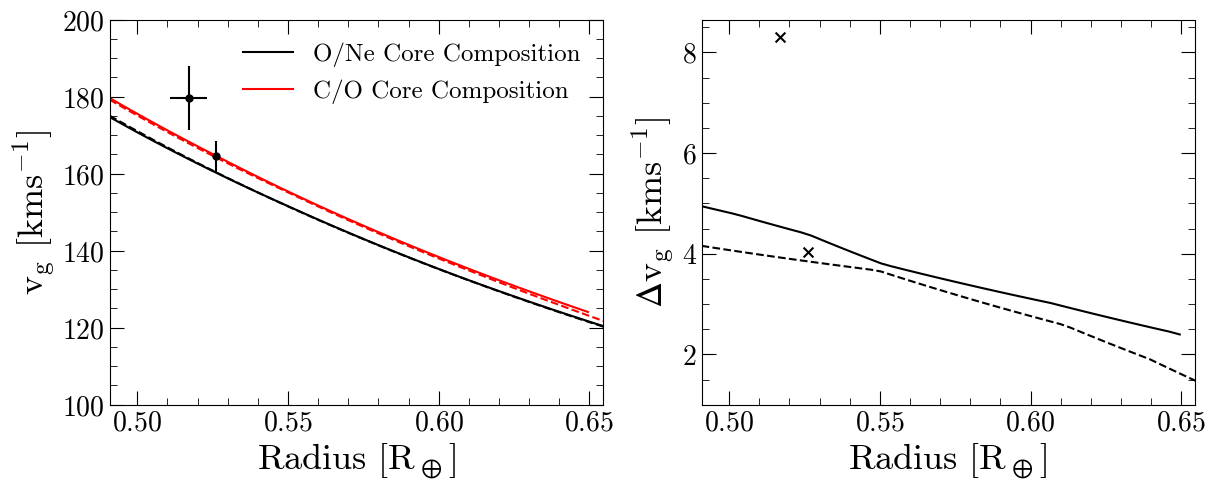

In [25]:
from matplotlib.patches import Ellipse

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(14, 5))

gravz = [164.5769784855582, 179.7]
e_gravz = [4.028667270172932, 8.3]
radius = [0.004822935258083884 * 109.075, 0.517]
e_radius = [4.6852468316256134e-08 * 109.075, 0.006]
colors = ['k', 'green']

# plot each of the four models
ax1.plot(rad_array * 109.075, vg_array_one_hrich, c = 'k', label='O/Ne Core Composition')
ax1.plot(rad_array * 109.075, vg_array_one_hdef, c = 'k', ls = '--')
ax1.plot(rad_array * 109.075, vg_array_co_hrich, c = 'r', label = 'C/O Core Composition')
ax1.plot(rad_array * 109.075, vg_array_co_hdef, c = 'r', ls = '--')
ax1.errorbar(radius, gravz, xerr = e_radius, yerr = e_gravz, fmt = 'o', c = 'k')
#for i in range(len(gravz)):
#    ellipse = Ellipse((radius[i], gravz[i]), width=2*e_radius[i], height=2*e_gravz[i],
#                        edgecolor='k', facecolor='none', linestyle='-', alpha = 0.7)
#    ax1.add_patch(ellipse)
# change the limits of the plot 
ax1.set_xlim(0.0045* 109.075, 0.006* 109.075)
ax1.set_ylim(100, 200)
# axis labels
ax1.set_xlabel(r'Radius [$R_\oplus$]')
ax1.set_ylabel(r'$v_g$ [$kms^{-1}$]')
ax1.legend(framealpha=0)

# plot the difference between the core composition models
ax2.plot(rad_array * 109.075, vg_array_co_hrich - vg_array_one_hrich, c = 'k')
ax2.plot(rad_array * 109.075, vg_array_co_hdef - vg_array_one_hdef, c = 'k', ls = '--')
ax2.scatter(radius, e_gravz, c = 'k', s = 50, marker='x')

#ax2.axhline(y = 1.4, label = 'Approx detectability threshold', c = 'red')#, zorder=0)
#ax2.legend(framealpha=0)
# change the limits of the plot
ax2.set_xlim(0.0045* 109.075, 0.006* 109.075)
#axis labels
ax2.set_xlabel(r'Radius [$R_\oplus$]')
ax2.set_ylabel(r'$\Delta v_g$ [$kms^{-1}$]')

## Sensitivity Testing

Next, I need to know what signal to noise ratio we'll need to achieve to get a sufficiently accurate radius. To do that, I've written a script called `vgsimulator.py` which takes the model template grid from `corv`, convolves it down to a specific resolution (for now I'll use $R = 3000$), then adds gaussian noise to a specific signal-to-noise ratio. The temperature and distance will be fixed, and the radius will be randomly sampled from a uniform distribution in the range in which we're interested. Another way to do this would be calculating everything on a fixed grid of radii, but this seems to work just fine. 

Because the base wavelength of the `corv` interpolator is very sparse, I'm going to reinterpolate it onto the wavelengths of an acutal SDSS spectrum. That will ensure that the result we get is as close as possible to an actual observation. The final result will be a plot like the one above on the right with contours of signal-to-noise ratio that will inform the proposal for observing time. 

In [6]:
from astropy.table import Table

test = Table.read('../data/raw/spect.SDSS J075523.89+194459.9.sdss.txt', format='ascii')
wavl = test['wavelength'].data

In [7]:
teff, distance = 12000, 200
snr_grid = np.linspace(5, 300, 25)
R1, R2, R3 = 1800, 6000, 18500
n_sims = 20

parameters_R1 = vgsimulator.simulate(wavl, n_sims, snr_grid, R1, teff, distance)
parameters_R2 = vgsimulator.simulate(wavl, n_sims, snr_grid, R2, teff, distance)
parameters_R3 = vgsimulator.simulate(wavl, n_sims, snr_grid, R3, teff, distance)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:15<?, ?it/s]
/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/fit.py:166: SyntaxWarning: invalid escape sequence '\c'
  plt.axhline(y = t_cc, label = 'Minimum $\chi^2$')
/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/utils.py:250: SyntaxWarning: invalid escape sequence '\s'
  base_wavl = np.array(re.split('\s+', ''.join(lines[1:ii])))[1:].astype(float)
/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/utils.py:264: SyntaxWarning: invalid escape sequence '\s'
  wavl = np.array(re.split('\s+', ''.join(lines[1:ii])))[1:].astype(float)
/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/utils.py:271: SyntaxWarning: invalid escape sequence '\s'
  teff = float(re.split('\s+', lines[prev_ii])[4])
/home/arsen/miniconda3/envs/core-composition/lib/python3.12/site-packages/corv/utils.py:272: SyntaxWarning: invalid escape sequence '\s'
  logg = np.log10(fl

KeyboardInterrupt: 

Text(0, 0.5, 'Flux $[erg/cm^{2}/s/\\AA]$')

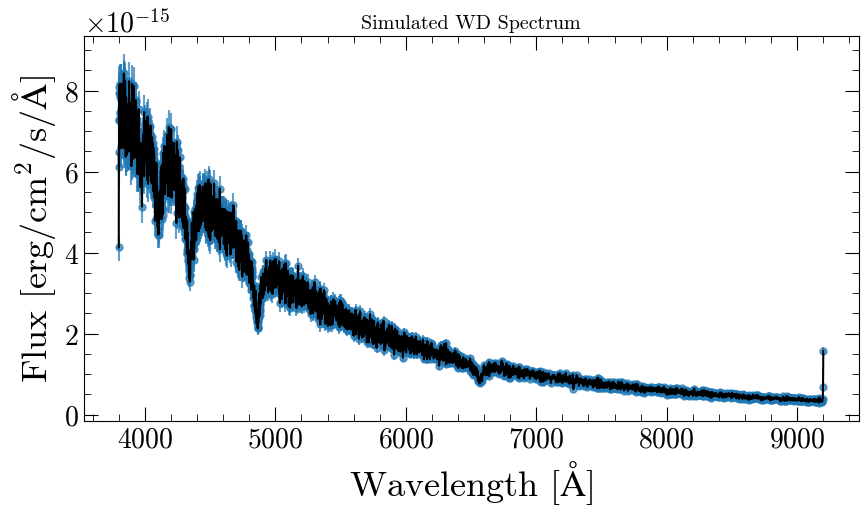

In [8]:
test_params = (29598.856100405897, 0.0058)
distance, rv, snr = 53.9, 17, 15
wl, flux, ivar = vgsimulator.simulate_spec(wavl, test_params, distance, rv, snr)

plt.figure(figsize=(10,5))
plt.title('Simulated WD Spectrum')
plt.errorbar(wl, flux, yerr=1/np.sqrt(ivar), fmt='o', alpha=0.7, zorder=0)
plt.plot(wl, flux, c = 'k')
plt.xlabel(r'Wavelength $[\AA]$')
plt.ylabel(r'Flux $[erg/cm^{2}/s/\AA]$')

Text(0, 0.5, '$\\Delta v_g$ $km s^{-1}$')

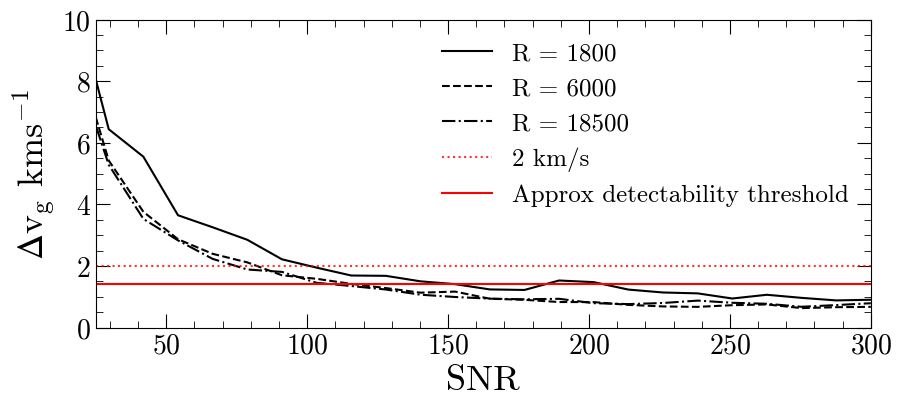

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(parameters_R1['snr'].data, parameters_R1['measured_e_rv'].data, c = 'k', label=f'R = {R1}')#, s = 5)
plt.plot(parameters_R2['snr'].data, parameters_R2['measured_e_rv'].data, c = 'k', ls = '--', label=f'R = {R2}')#, s = 5)
plt.plot(parameters_R3['snr'].data, parameters_R3['measured_e_rv'].data, c = 'k', ls = 'dashdot', label=f'R = {R3}')#, s = 5)


plt.axhline(y = 2, label = '2 km/s', c = 'red', ls = ':', alpha = 0.8)#, zorder=0)
plt.axhline(y = 1.4, label = 'Approx detectability threshold', c = 'red')#, zorder=0)
plt.legend(framealpha=0)
plt.ylim(0, 10)
plt.xlim(25, 300)
plt.xlabel('SNR')
plt.ylabel(r'$\Delta v_g$ $km s^{-1}$')


In [10]:
parameters_R1.write('../data/cleaned/simulation_R1.csv', overwrite=True)
parameters_R2.write('../data/cleaned/simulation_R2.csv', overwrite=True)
parameters_R3.write('../data/cleaned/simulation_R3.csv', overwrite=True)